In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map,  path_s3 = "veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations
#files

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/


In [2]:
fireID = '0'
gdf = fv.load_large_fire(fireID, year = "2021", path_region="Caldor")
gdf['timediff'] = gdf.t.astype("datetime64[ns]") - pd.to_datetime("2021-08-14 18:00:00")
gdf['timediff'] = gdf.timediff.astype("int")
#gdf["t"] = gdf["t"].astype("str")
gdf.t.astype("datetime64[ns]")
gdf = gdf.sort_values(by = ["t"])


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [3]:
#foi = gdf
#foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
#foi = foi.iloc[0] # First element

foi = [{"Lat":38.586 , 
        "Lon":-120.537833 
    
}]
foi = pd.DataFrame(foi)

st_cls = fv.closest(st_dict, foi)

## Get station Data
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

#gdf = gdf.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
#gdf['t'] = gdf['t'].astype('datetime64[ns]')
#gdf['t'] = gdf["t"] + datetime.timedelta(hours = 1, minutes= 30) ## Realign with sat passover times

#gdf_night = gdf[gdf.t.dt.hour > 2]
#gdf = gdf[gdf.t.dt.hour > 2] ### Only daytime hours
gdf = gdf[gdf.t.dt.hour > 0]

gdf["fline_diff"] = gdf.flinelen.diff() ## Add flireline difference for analysis later
gdf["farea_diff"] = gdf.farea.diff()
gdf["farea_second_diff"] = gdf.farea_diff.diff()

#gdf = gdf[gdf.t.astype("datetime64[ns]").hour > "00:00:00"]
#print(gdf.flinelen.diff() )

#print(gdf["fline_diff"].iloc[0:24])

full_fr = fv.fr_st_merge(gdf, st, sub = True)
#full_fr_night = fv.fr_st_merge(gdf_night, st, sub = True)

The closest station is 23.48698806042275 km away.


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [4]:
time_of_interest = 24
hours_before = 0

max_spread = max(full_fr.fline_diff[full_fr.fline_diff.notna()])
print(max_spread)
print(max_spread *0.15)

35.71914311192666
5.357871466788999


In [5]:
daytime = ['7','8','9','10','11','12','13','14','15','16','17','18'] # My def of daytime



full_fr["is_daytime"] = full_fr.HH.isin(daytime)
full_fr["flinlen_day"] = full_fr.flinelen

# mask = np.invert(full_fr.is_daytime)
# full_fr.flinlen_day.loc[mask] = np.nan
# #full_fr["flinlen_day_diff"] = 
# #full_fr.is_daytime.unique()

### Fire area differnce
full_fr["spread_line"] = ((full_fr["farea_diff"] > 0) & (full_fr["farea_diff"] > (max_spread * 0.95)))
#full_fr["spread_line"] = ((full_fr["fline_diff"] > 0)) #& (full_fr["fline_diff"] > (max_spread * 0.15)))

#full_fr["t_lag"] = full_fr["t"] - np.timedelta64(time_lag, 'h')
times = full_fr["t"].loc[full_fr["spread_line"] ]
times_not = full_fr["t"].loc[full_fr["spread_line"] == False]
times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]
#print("TIMES:", times)
#print("TIMES_NOT:", times_not)
#times_start = times - np.timedelta64(time_lag, "h")

full_fr["sumFRP"] = full_fr.meanFRP * full_fr.n_newpixels

full_fr["flinlen_day"] = full_fr.flinelen

mask = np.invert(full_fr.is_daytime)
full_fr.flinlen_day.loc[mask] = np.nan
#full_fr["flinlen_day_diff"] = 
#full_fr.is_daytime.unique()

/tmp/ipykernel_5155/1411050197.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr.flinlen_day.loc[mask] = np.nan


In [6]:
full_fr["spread_day"] = np.nan
for t in times:
    times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = t - np.timedelta64((hours_before), "h")
    full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
    

for l in times_not:
    times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = l - np.timedelta64((hours_before), "h")
    full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False
    
# full_fr["spread_day"] = False
# for t in times:
#     times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
#     times_end = t - np.timedelta64((hours_before), "h")
#     full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
full_fr["spread_day"]

/tmp/ipykernel_5155/3674384972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


0        NaN
1       True
2       True
3       True
4        NaN
        ... 
1604     NaN
1605     NaN
1606     NaN
1607     NaN
1608     NaN
Name: spread_day, Length: 1609, dtype: object

<AxesSubplot: xlabel='t', ylabel='farea'>

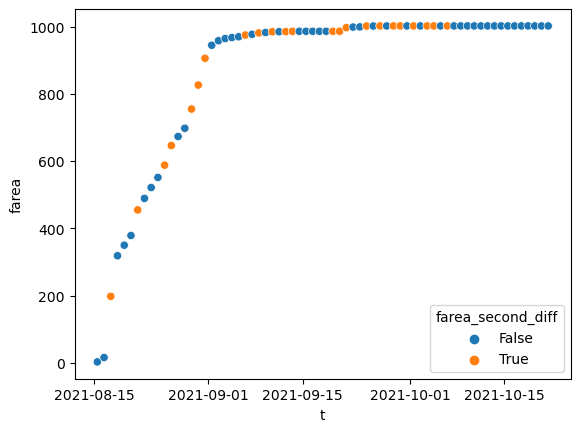

In [7]:
full_fr = full_fr.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
full_fr['t'] = full_fr['t'].astype('datetime64[ns]')


import seaborn as sns
sns.scatterplot(x = full_fr.t, y =full_fr.farea, hue = full_fr.farea_second_diff > 0)

1001.9556736701105
55.88235294117647
0          0
1          1
2          2
3          3
4          4
        ... 
1604    1604
1605    1605
1606    1606
1607    1607
1608    1608
Length: 1609, dtype: int64


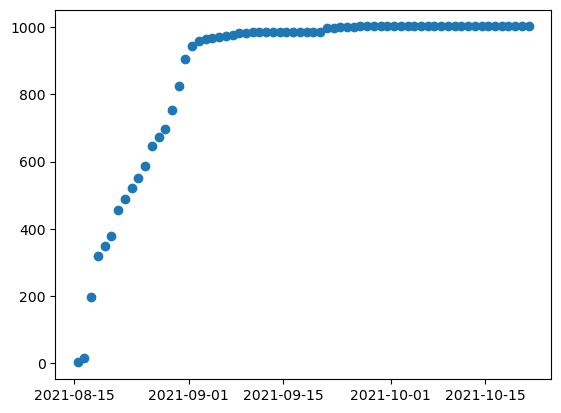

In [8]:
print(max(full_fr.farea)) # 1002 is asymptote

delta_area = 950/17 # (I eyeballed this)
print(delta_area)

plt.scatter(x = full_fr.t, y =full_fr.farea)
series = pd.Series(range(0, len(full_fr.t)))
print(series)
#plt.plot(full_fr.t, ((1002*series) - 1008)/(series + 52)) ## An exponential function Not a great fit honestly. Need something sigmoidal?
#plt.plot(full_fr.t, (1/(1 + np.exp(-series))) * 1002) # Logistic not great either
#plt.plot(full_fr.t, (series/(1 + np.abs(series))) * 1002)

<AxesSubplot: xlabel='t', ylabel='farea_diff'>

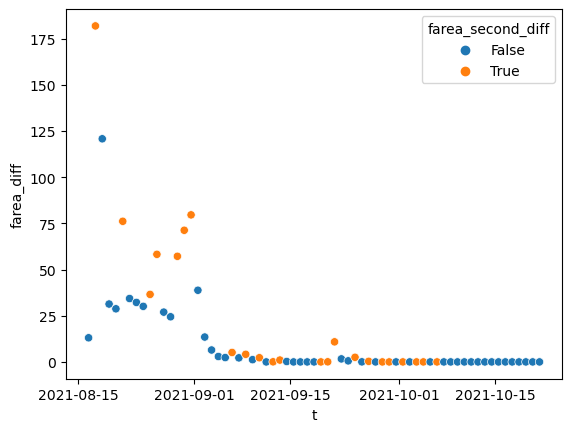

In [9]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff, hue = full_fr.farea_second_diff > 0)

[            nan  8.36083284e-01  9.20882696e-01  3.79471934e-01
  8.96373845e-02  7.59950356e-02  1.67495029e-01  7.01913592e-02
  6.18170554e-02  5.45815233e-02  6.21983861e-02  9.01731662e-02
  4.00623900e-02  3.50444858e-02  7.57827815e-02  8.63036595e-02
  8.79222564e-02  4.10912013e-02  1.40652858e-02  6.68971656e-03
  3.03369085e-03  2.43191433e-03  5.25703106e-03  2.25272031e-03
  4.19944985e-03  1.24428720e-03  2.30284879e-03 -8.08204783e-16
  5.88261081e-05  1.02437849e-03  2.32619129e-04  1.96020098e-15
  0.00000000e+00 -1.49897722e-15 -2.30611880e-16  5.67746351e-05
  1.09061490e-02  1.64036140e-03  5.78559526e-04  2.49717242e-03
  3.68457525e-05  3.14617151e-04 -4.53859749e-16  2.04236887e-15
 -1.81543900e-15 -3.40394812e-16  4.53859749e-16 -1.13464937e-15]
1609


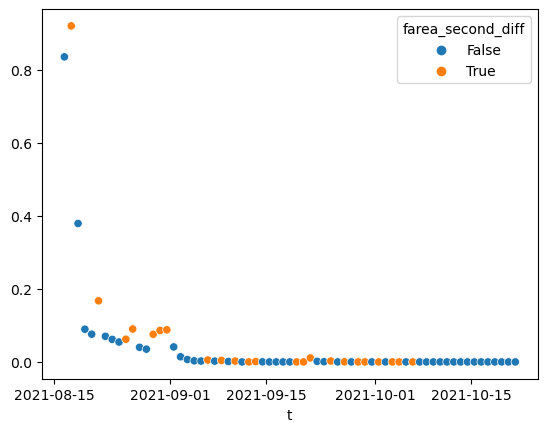

In [10]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff/full_fr.farea, hue = full_fr.farea_second_diff > 0)
area_corrected = full_fr.farea_diff/full_fr.farea
print(area_corrected.unique() )
print(len(series))

<AxesSubplot: xlabel='t', ylabel='farea_diff'>

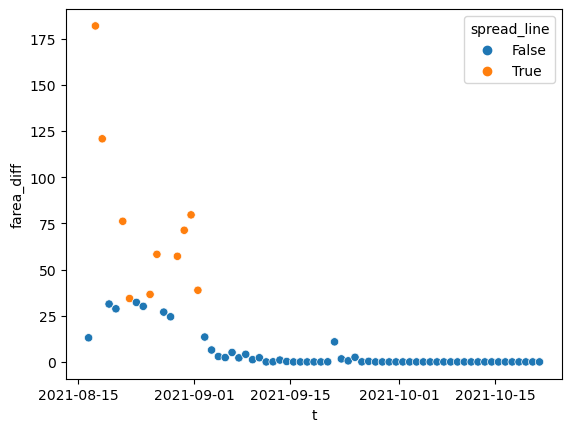

In [11]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff, hue = full_fr.spread_line)

<AxesSubplot: xlabel='t', ylabel='farea_diff'>

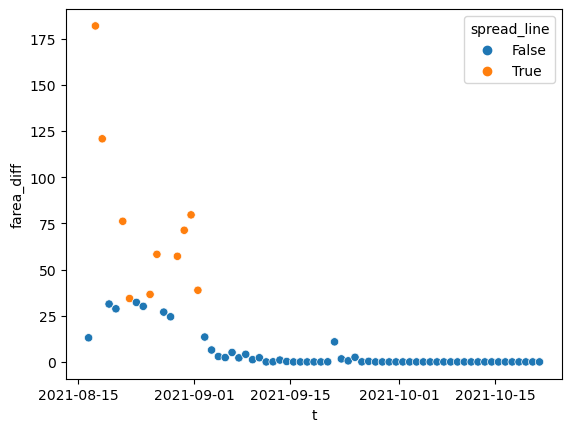

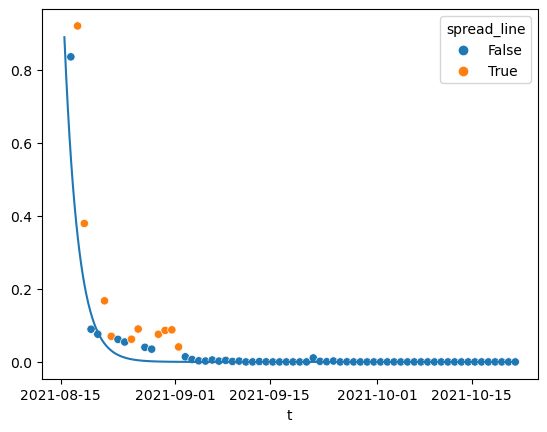

In [12]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff/full_fr.farea, hue = full_fr.spread_line)
series2 = [1.0, series[1:]]
series2 = pd.Series(series2)
#print(series2.unique)
plt.plot(full_fr.t.iloc[1:], 0.908*np.exp(-0.0201 * series.iloc[1:]))

<AxesSubplot: xlabel='t', ylabel='farea'>

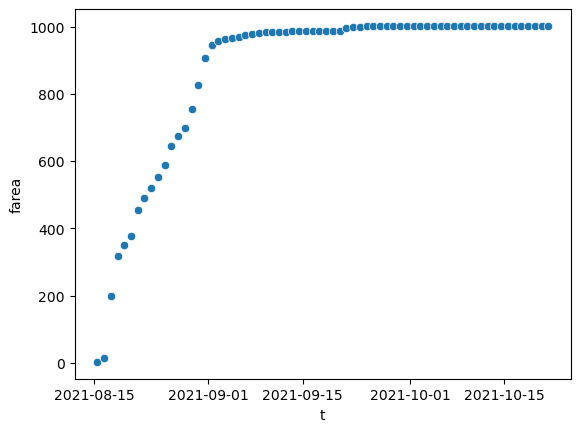

In [13]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea)

/tmp/ipykernel_5155/1261706362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_corrected[diff_corrected < 1] = np.nan


<AxesSubplot: xlabel='t'>

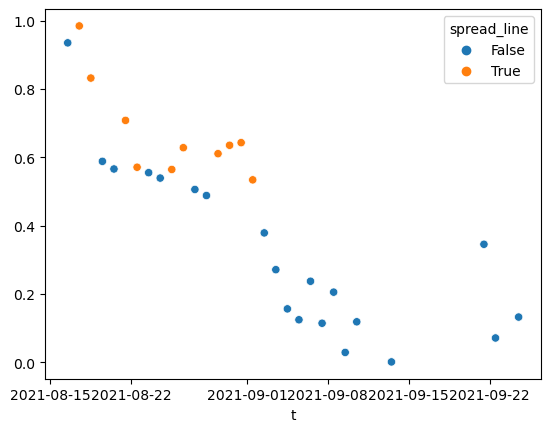

In [14]:
### Logging both sides? 

diff_corrected = full_fr.farea_diff
diff_corrected[diff_corrected < 1] = np.nan
sns.scatterplot(x = full_fr.t, y = np.log(diff_corrected)/np.log(full_fr.farea), hue = full_fr.spread_line)

<AxesSubplot: xlabel='farea_diff', ylabel='Count'>

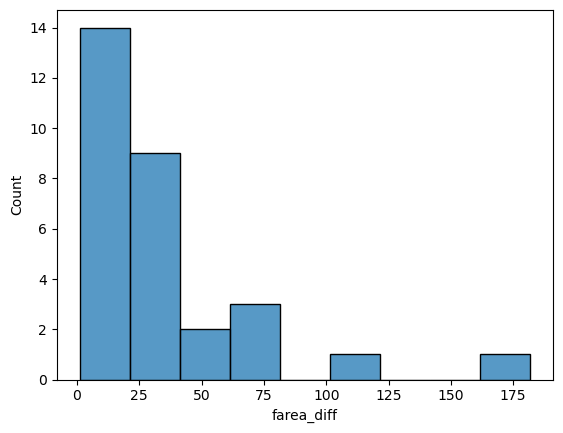

In [15]:
sns.histplot(full_fr.farea_diff)


<AxesSubplot: xlabel='t', ylabel='farea_second_diff'>

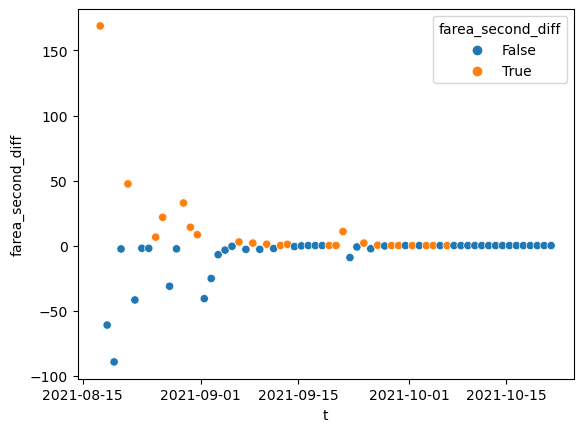

In [16]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_second_diff, hue = full_fr.farea_second_diff > 0)

<AxesSubplot: xlabel='t', ylabel='flinelen'>

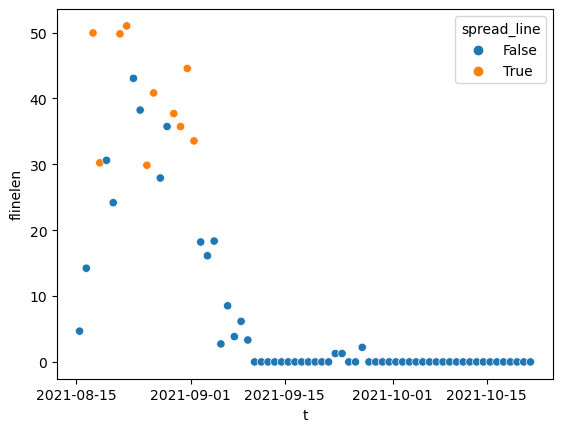

In [17]:
sns.scatterplot(x = full_fr.t, y = full_fr.flinelen, hue = full_fr.spread_line)

<AxesSubplot: xlabel='TEMP_C', ylabel='farea_diff'>

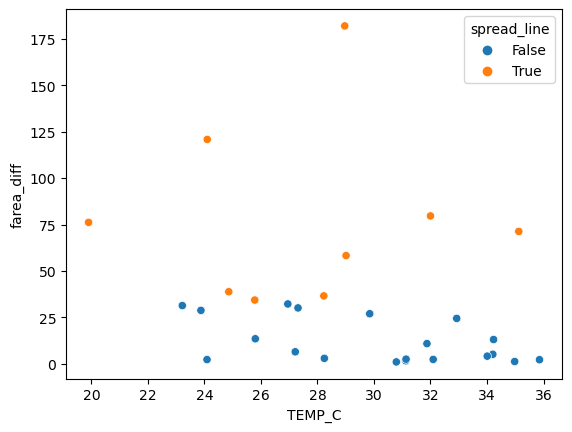

In [18]:
sns.scatterplot(x = full_fr.TEMP_C, y = full_fr.farea_diff, hue = full_fr.spread_line) # Oh shit that looks pretty good. 

In [19]:
full_fr.timediff.unique()

array([6.4800e+13,        nan, 1.5120e+14, 2.3760e+14, 3.2400e+14,
       4.1040e+14, 4.9680e+14, 5.8320e+14, 6.6960e+14, 7.5600e+14,
       8.4240e+14, 9.2880e+14, 1.0152e+15, 1.1016e+15, 1.1880e+15,
       1.2744e+15, 1.3608e+15, 1.4472e+15, 1.5336e+15, 1.6200e+15,
       1.7064e+15, 1.7928e+15, 1.8792e+15, 1.9656e+15, 2.0520e+15,
       2.1384e+15, 2.2248e+15, 2.3112e+15, 2.3976e+15, 2.4840e+15,
       2.5704e+15, 2.6568e+15, 2.7432e+15, 2.8296e+15, 2.9160e+15,
       3.0024e+15, 3.0888e+15, 3.1752e+15, 3.2616e+15, 3.3480e+15,
       3.4344e+15, 3.5208e+15, 3.6072e+15, 3.6936e+15, 3.7800e+15,
       3.8664e+15, 3.9528e+15, 4.0392e+15, 4.1256e+15, 4.2120e+15,
       4.2984e+15, 4.3848e+15, 4.4712e+15, 4.5576e+15, 4.6440e+15,
       4.7304e+15, 4.8168e+15, 4.9032e+15, 4.9896e+15, 5.0760e+15,
       5.1624e+15, 5.2488e+15, 5.3352e+15, 5.4216e+15, 5.5080e+15,
       5.5944e+15, 5.6808e+15, 5.7672e+15, 5.8536e+15])

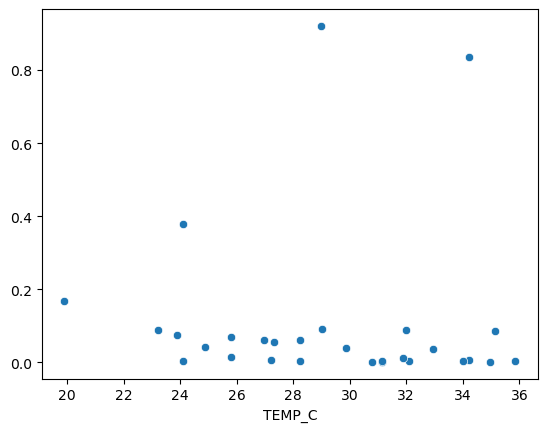

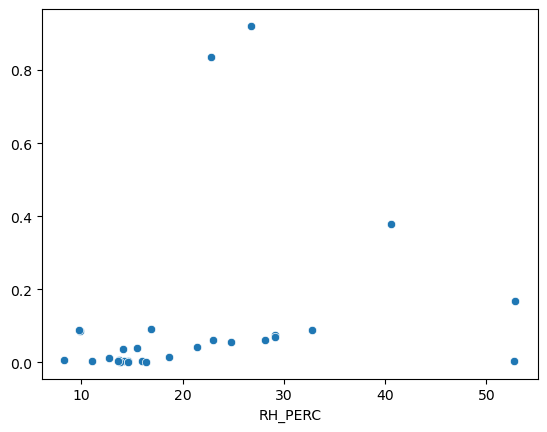

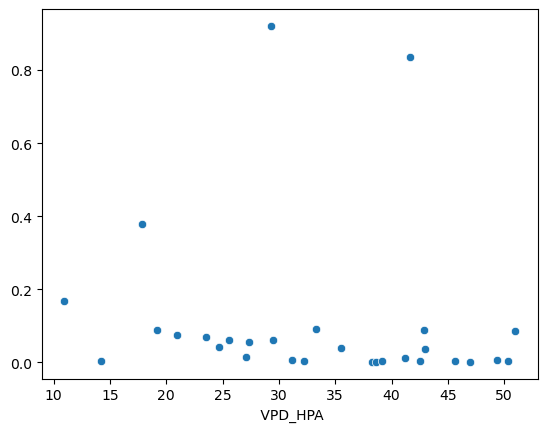

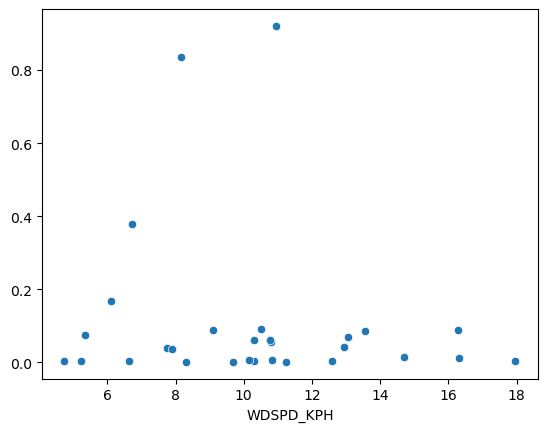

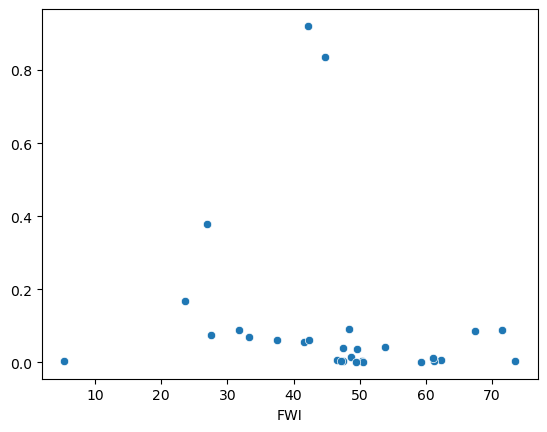

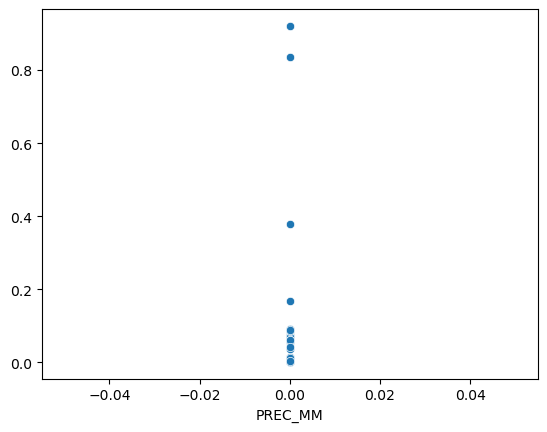

In [20]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']

for m in met:
    plt.figure()
    sns.scatterplot(x = full_fr[m], y = full_fr.farea_diff/full_fr.farea) ## The relationship between fire area anf temp seems time sensitive. (Which we would expect -- fire becomes more "self sustaining" later) ## Could this be autocorrelation? Need more fires. This might be just pitting out the logarithmic growth looking curve -- rh looks  
    
    
    

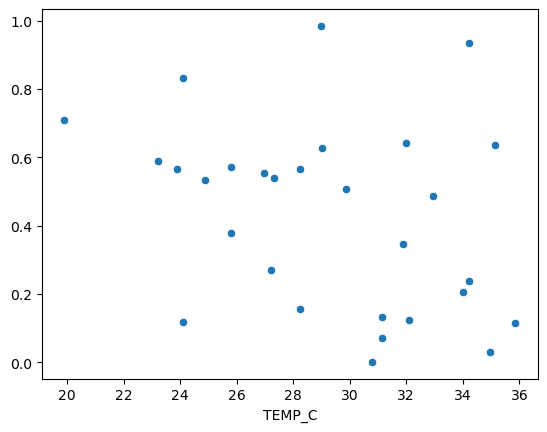

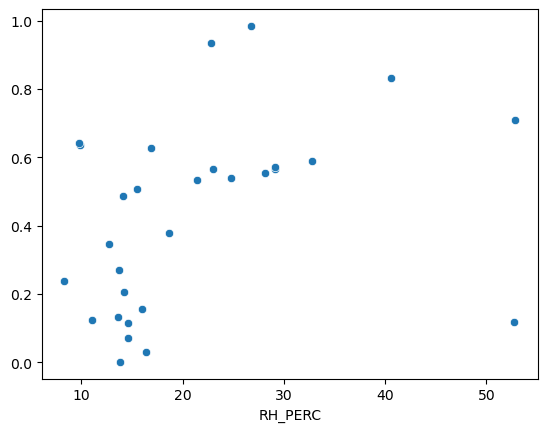

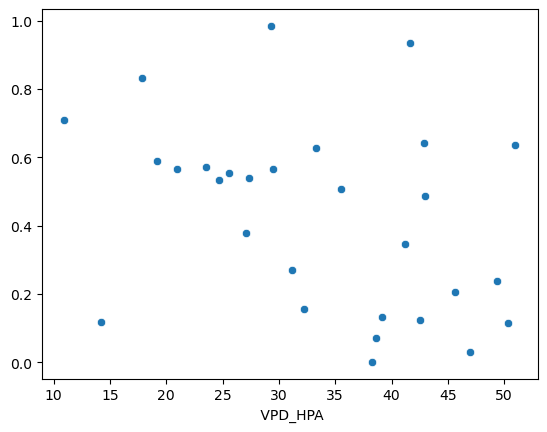

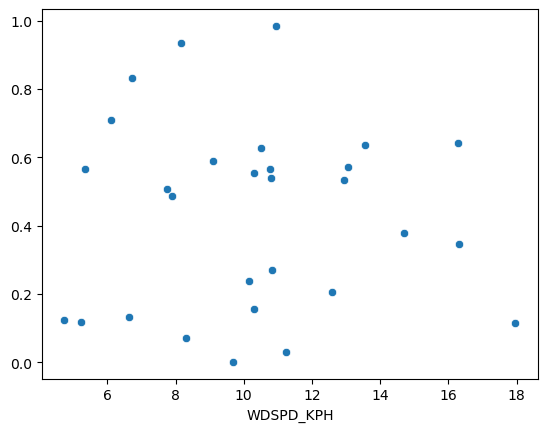

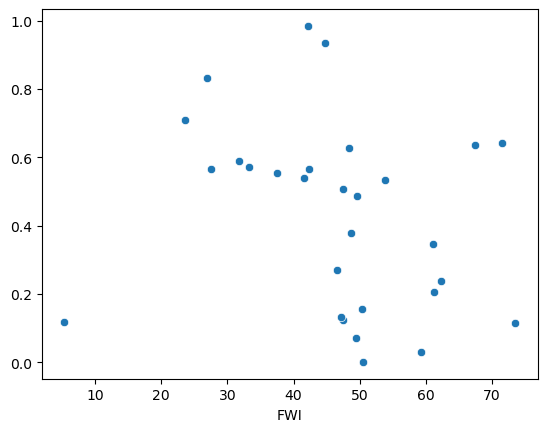

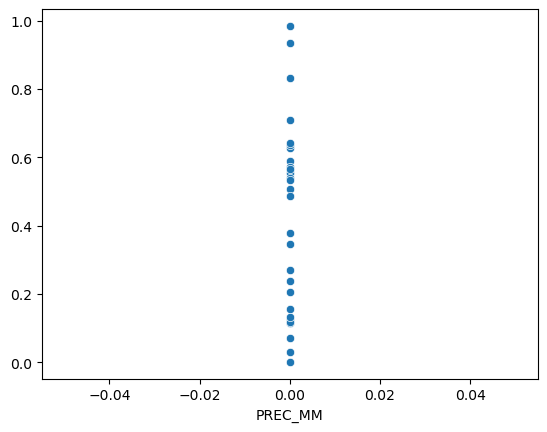

In [21]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']

for m in met:
    plt.figure()
    sns.scatterplot(x = full_fr[m], y = np.log(diff_corrected)/np.log(full_fr.farea)) ## The relationship between fire area anf temp seems time sensitive. (Which we would expect -- fire becomes more "self sustaining" later) ## Could this be autocorrelation? Need more fires. This might be just pitting out the logarithmic growth looking curve -- rh looks  

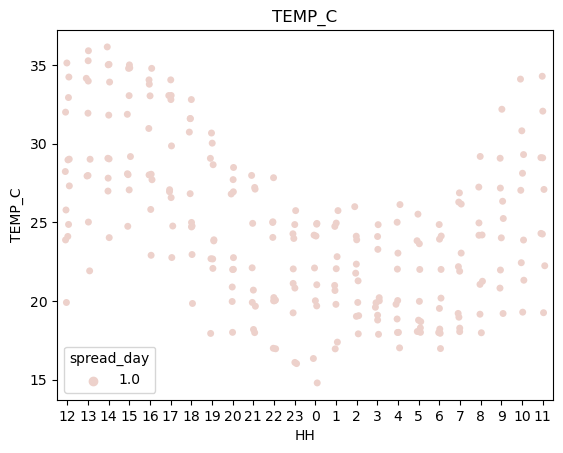

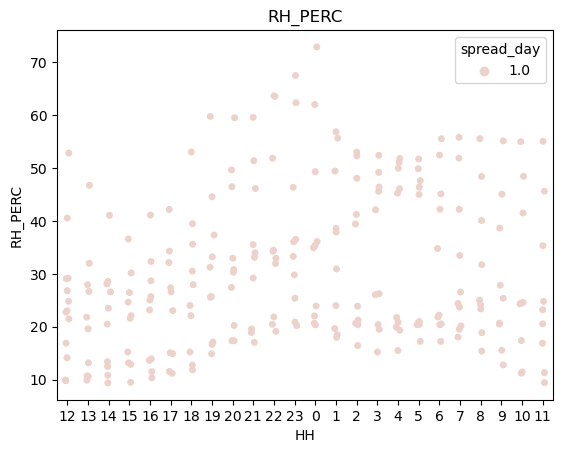

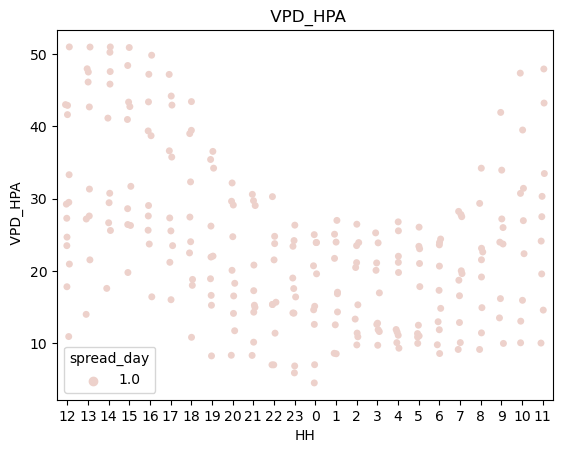

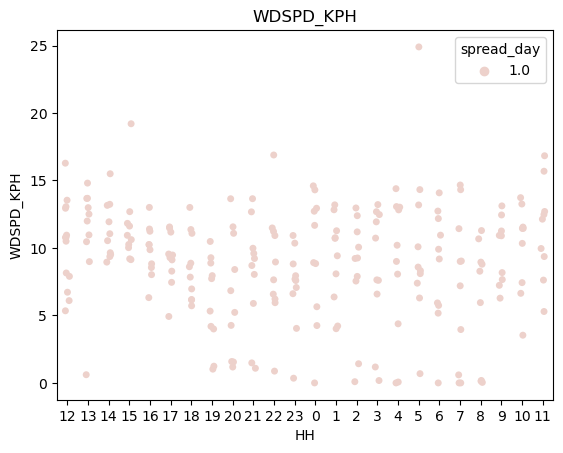

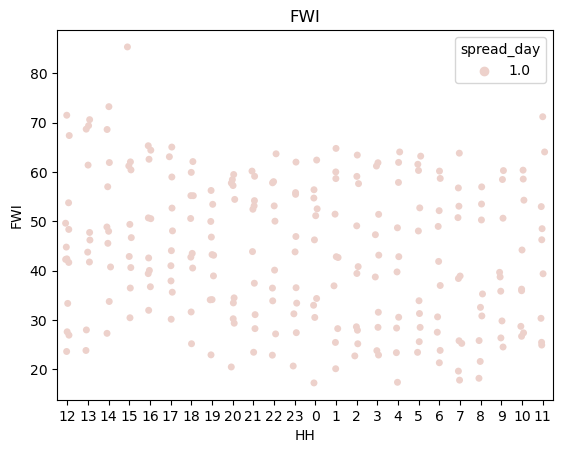

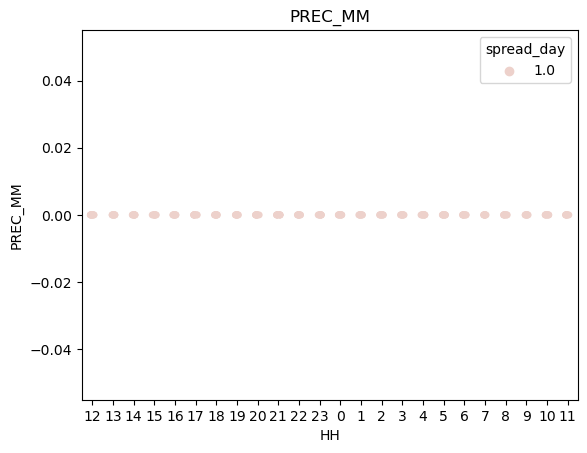

In [22]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']


#for m in met:
#    plt.scatter(x = full_fr['HH'], y = full_fr[m], c = full_fr["spread_day"], s = 0.9)
#    plt.title(m)
#    plt.show()

    
# for m in met:
#    sns.violinplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["spread_day"])
#    plt.title(m)
#    plt.show()  
    
# for m in met:
#     sns.stripplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["is_daytime"], dodge = True)
#     plt.title(m)
#     plt.show()  

for m in met:
    sns.stripplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["spread_day"], dodge = True)
    plt.title(m)
    plt.show()

In [23]:
## Compare GOES data in diurnal framework

caldor_perimeters = gpd.read_file('/projects/shared-buckets/ashiklom/CALDOR_sbs/caldor_perimeter_ts.geojson')
caldor_pixels = gpd.read_file('/projects/shared-buckets/ashiklom/CALDOR_sbs/caldor_pixel_ts.geojson')
goes = pd.read_csv('/projects/shared-buckets/ashiklom/CALDOR_sbs/GOES17_CaldorFire.csv')
goes = gpd.GeoDataFrame(goes, 
                        geometry=gpd.points_from_xy(goes.lon, goes.lat),
                       crs='EPSG:4236')
goes.to_crs(caldor_pixels.crs,inplace=True)
goes['dt'] = pd.to_datetime(goes['date'])
goes = goes.rename(columns= {"geometry": "point_location_goes"})
goes = goes.rename(columns= {"frp": "frp_goes"})
caldor_pixels = caldor_pixels.rename(columns= {"geometry": "point_location"})
caldor_pixels = caldor_pixels.rename(columns= {"frp": "frp_viirs"})
caldor_pixels["t"] = caldor_pixels['datetime']
goes['t'] = goes['dt']

In [24]:
print(goes.columns)
print(caldor_pixels.columns)

Index(['date', 'lat', 'lon', 'frp_goes', 'point_location_goes', 'dt', 't'], dtype='object')
Index(['t', 'x', 'y', 'frp_viirs', 'DS', 'DT', 'ampm', 'datetime', 'sat',
       'point_location'],
      dtype='object')


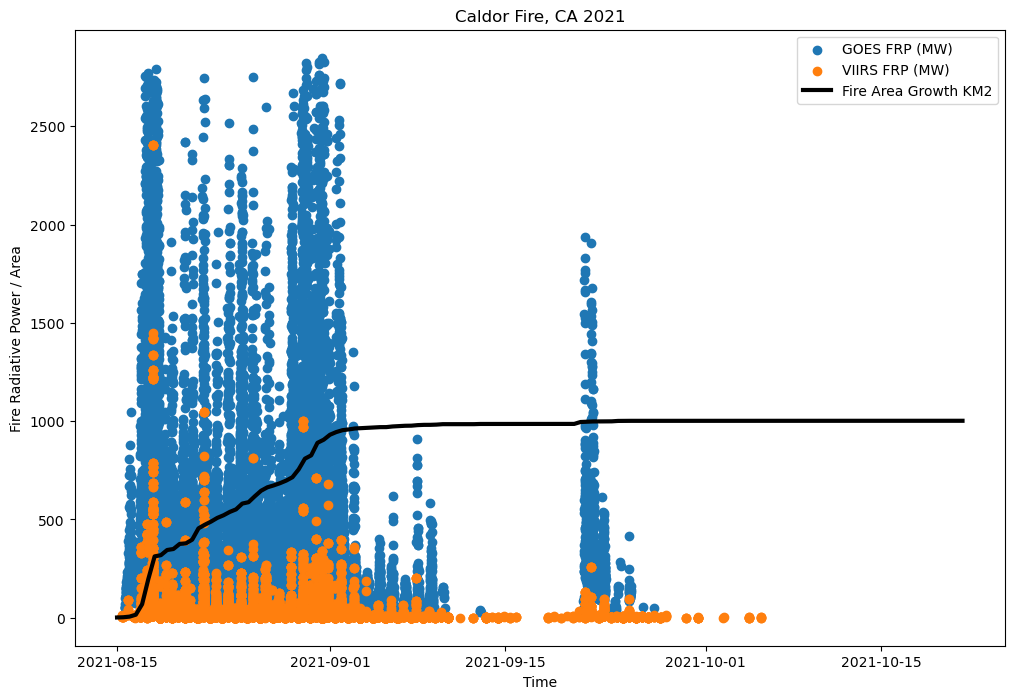

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(goes['dt'],goes['frp_goes'],label='GOES FRP (MW)')
ax.scatter(caldor_pixels['datetime'],caldor_pixels['frp_viirs'],label='VIIRS FRP (MW)')
ax.plot(pd.to_datetime(caldor_perimeters['t']),caldor_perimeters['farea'],
         c='k',linewidth=3,label='Fire Area Growth KM2')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Fire Radiative Power / Area')
plt.title("Caldor Fire, CA 2021")
#ax2=ax.twinx()
#ax2.plot(pd.to_datetime(full_fr.t), full_fr.FWI,color="purple",  alpha=0.3, label = "FWI")
#ax2.legend(loc = 'upper center')
#ax2.set_ylabel("FWI",color="purple")
plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/caldor_fire_frp.png", dpi=800)

In [26]:
## Need to merge all datasets
all_fr = pd.merge(full_fr, goes, on = "t", how = "outer")

all_fr = pd.merge(all_fr, caldor_pixels, on = "t", how = "outer")

all_fr


,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,geometry,...,dt,x,y,frp_viirs,DS,DT,ampm,datetime,sat,point_location
0,22.0,10.0,2.562399,6.480056,4.673455,0.5,8.585704,52.927,2021-08-15 12:00:00,"POLYGON ((-120.50077 38.59440, -120.50064 38.5...",...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 13:00:00,None,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 14:00:00,None,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,None
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 15:00:00,None,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 16:00:00,None,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-04 10:12:00,None,...,NaT,-1.725220e+06,-484594.649071,1.27,0.417050,0.523834,AM,2021-10-04 10:12:00,SNPP,POINT (755531.901 4293319.875)
42892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-05 09:54:00,None,...,NaT,-1.726815e+06,-487507.366349,1.96,0.361919,0.386084,AM,2021-10-05 09:54:00,SNPP,POINT (754729.524 4290097.268)
42893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-05 09:54:00,None,...,NaT,-1.723615e+06,-486988.489689,1.22,0.362010,0.386292,AM,2021-10-05 09:54:00,SNPP,POINT (757707.465 4291461.243)
42894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-05 09:54:00,None,...,NaT,-1.725065e+06,-484626.566749,0.58,0.361931,0.386113,AM,2021-10-05 09:54:00,SNPP,POINT (755690.505 4293331.209)


In [27]:
## Try to include goes in spread day vs non spread day


all_fr["spread_day"] = np.nan

for t in times:
    times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = t - np.timedelta64((hours_before), "h")
    all_fr.spread_day[(all_fr["t"] >= times_start) & (all_fr["t"] <= times_end)] = True
    

for l in times_not:
    times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = l - np.timedelta64((hours_before), "h")
    all_fr.spread_day[(all_fr["t"] >= times_start) & (all_fr["t"] <= times_end)] = False
    
# full_fr["spread_day"] = False
# for t in times:
#     times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
#     times_end = t - np.timedelta64((hours_before), "h")
#     full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
all_fr["spread_day"]

/tmp/ipykernel_5155/3335193065.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_fr.spread_day[(all_fr["t"] >= times_start) & (all_fr["t"] <= times_end)] = True


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
42891    NaN
42892    NaN
42893    NaN
42894    NaN
42895    NaN
Name: spread_day, Length: 42896, dtype: object

In [28]:
all_fr = all_fr.sort_values(by = ['t'])

<AxesSubplot: xlabel='t', ylabel='farea'>

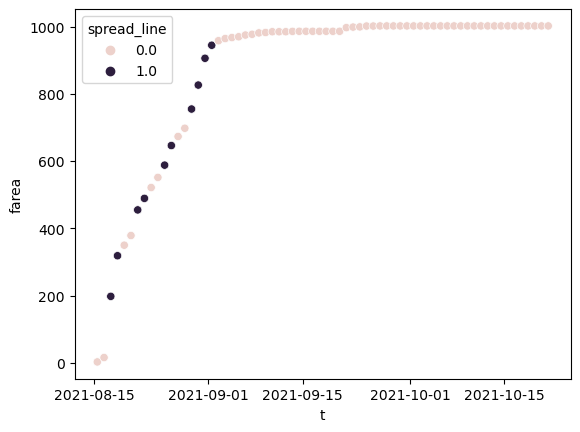

In [50]:
sns.scatterplot(x = all_fr.t, y = all_fr.farea, hue = all_fr.spread_line)

In [49]:
tmp_fr = all_fr[all_fr.t < "2021-10-01"]
plt.scatter(tmp_fr.t, tmp_fr.farea, hue = tmp_fr.spread_line) #color = "black"
plt.xticks(rotation=90)
#plt.

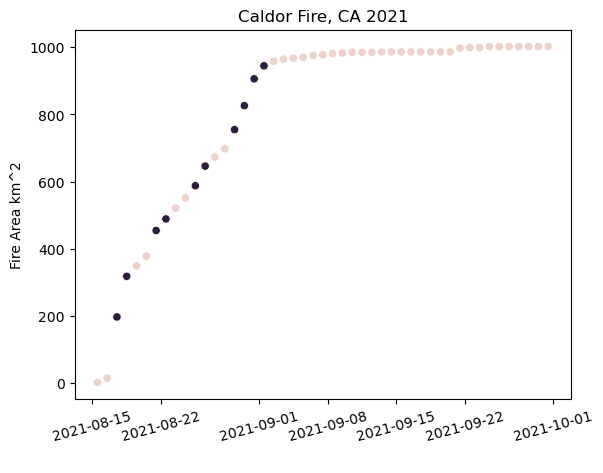

In [62]:
sns.scatterplot(x = tmp_fr.t, y = tmp_fr.farea, hue = tmp_fr.spread_line)
plt.legend([],[], frameon=False)
plt.xticks(rotation=15)
plt.ylabel("Fire Area km^2")
plt.xlabel(" ")
plt.title("Caldor Fire, CA 2021")

plt.savefig("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/2023_CMS_figures/caldor_fire_area.png", dpi=800)

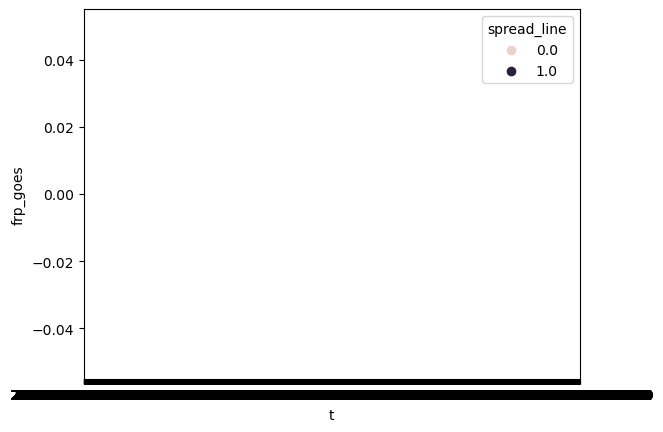

In [51]:
#sns.stripplot(x = all_fr.t, y = all_fr.frp_goes, hue = full_fr["spread_day"], dodge = True)
#plt.title("Goes FRP")
#plt.show()

sns.stripplot(x = all_fr.t, y = all_fr.frp_goes, hue = all_fr["spread_line"])
plt.show()

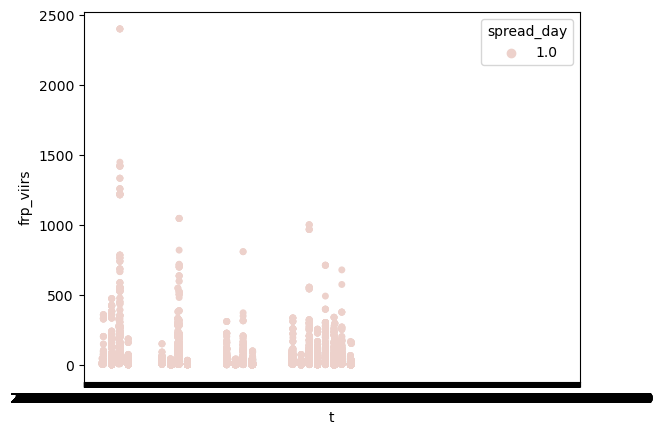

In [31]:
sns.stripplot(x = all_fr.t, y = all_fr.frp_viirs, hue = all_fr["spread_day"])
plt.show()

In [32]:
all_fr["HH_again"] = all_fr.t.dt.hour

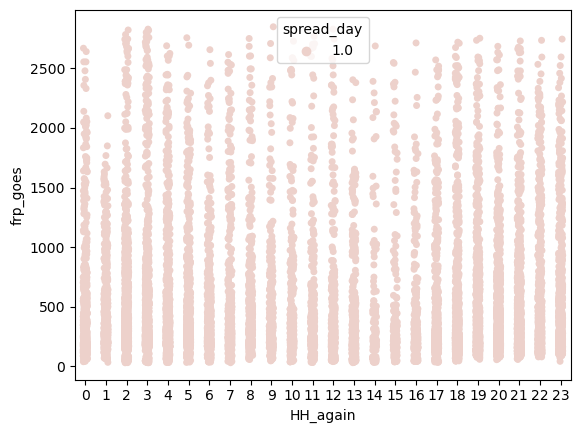

In [33]:
sns.stripplot(x = all_fr.HH_again, y = all_fr.frp_goes, hue = all_fr["spread_day"], dodge = True)
plt.show()

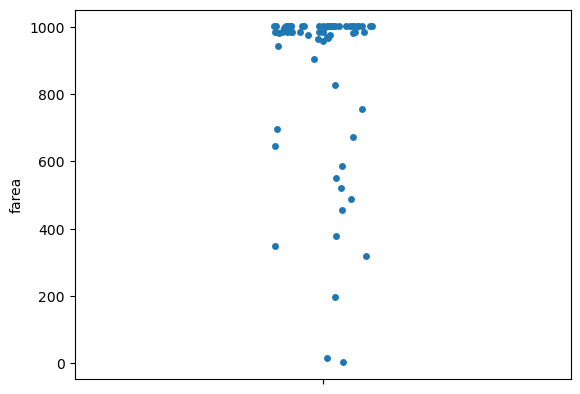

In [147]:

st = st.rename(columns={"time": "t"})
right_join = pd.merge(gdf, st, on = "t" )
full_fr

,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,geometry,...,OBSMINUTEDIFFRH,OBSMINUTEDIFFWDSPD,OBSMINUTEDIFFPREC,OBSMINUTEDIFFSNOW,HH_format,is_daytime,flinlen_day,spread_line,sumFRP,spread_day
0,22.0,10.0,2.562399,6.480056,4.673455,0.5,8.585704,52.927,2021-08-15 13:30:00,"POLYGON ((-120.50077 38.59440, -120.50064 38.5...",...,NaN,NaN,NaN,NaN,NaN,False,NaN,False,529.27,False
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 14:00:00,None,...,5.0,5.0,5.0,NaN,14,True,NaN,False,NaN,True
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 15:00:00,None,...,5.0,5.0,5.0,NaN,15,True,NaN,False,NaN,True
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 16:00:00,None,...,5.0,5.0,5.0,NaN,16,True,NaN,False,NaN,True
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-15 17:00:00,None,...,5.0,5.0,5.0,NaN,17,True,NaN,False,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-21 10:00:00,None,...,5.0,5.0,5.0,NaN,10,True,NaN,False,NaN,True
1673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-21 11:00:00,None,...,5.0,5.0,5.0,NaN,11,True,NaN,False,NaN,True
1674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-21 12:00:00,None,...,5.0,5.0,5.0,NaN,12,True,NaN,False,NaN,True
1675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-21 13:00:00,None,...,5.0,5.0,5.0,NaN,13,True,NaN,False,NaN,True


In [138]:
#?pd.merge

In [145]:
#sns.stripplot(x = right_join.farea, y = right_join.TEMP_C)

right_join.farea
right_join.TEMP_C

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
63   NaN
64   NaN
65   NaN
66   NaN
67   NaN
Name: TEMP_C, Length: 68, dtype: float64